# Book Recommender System
## MS Capstone Project
<div>
<img src="https://miro.medium.com/max/2722/1*BE61Ks1IZdXMv2MnIKSH1g.png" width="900"/>
</div>
Recommender systems have become an integral part of many e-commerce companies. From Amazon to Netflix, recommender systems help users to explore items/ songs/ movies which are similar to their tastes. They also have significantly impacted businesses by increasing purchases resulting in increased revenue. This project builds a recommender system from books whose details are stored in the good reads database. Many advances have been made in identifying best algorithms to make these recommendations. This project explores 3 popular ones. Content-based filtering approach uses the book titles and ratings to suggest books to users. In the collaborative filtering (CF) approach, user-user as well as item-item approach have been explored. Finally, I have applied the Singular Value Decomposition (SVD) which is one of the most popular approaches.


### Importing the libraries

In [76]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer #Perform TF-IDF
from spacy import displacy
from sklearn.model_selection import train_test_split
from IPython.display import Image, HTML   #Displaying images
from wordcloud import WordCloud, ImageColorGenerator #Form wordcloud
from sklearn.metrics.pairwise import cosine_similarity #Find cosine similarity
from sklearn.metrics.pairwise import pairwise_distances #Compute the distance matrix from a vector array X and optional Y
from sklearn.metrics import mean_squared_error
from math import sqrt


### Reading the data

In [77]:
#reading the books file
books = pd.read_csv('data/books.csv', encoding = "ISO-8859-1")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [3]:
books.shape

(10000, 23)

The books table has 10,000 observations and 23 columns.

In [78]:
#reading the book tags file
book_tags = pd.read_csv('data/book_tags.csv', encoding = "ISO-8859-1")
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [5]:
book_tags.shape

(999912, 3)

The book tags table has 999912 observations and 3 columns

In [80]:
#reading the ratings file
ratings = pd.read_csv('data/ratings.csv', encoding = "ISO-8859-1")
ratings.head()


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [81]:
ratings.shape

(981756, 3)

In [82]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
book_id    981756 non-null int64
user_id    981756 non-null int64
rating     981756 non-null int64
dtypes: int64(3)
memory usage: 22.5 MB


In [83]:
#reading the tags file
tags = pd.read_csv('data/tags.csv', encoding = "ISO-8859-1")
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [84]:
tags.shape

(34252, 2)

The tags table has 34252 rows and 2 columns

In [85]:
#reading the to_read file
to_read = pd.read_csv('data/to_read.csv', encoding = "ISO-8859-1")
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [12]:
to_read.shape

(912705, 2)

The table to_read has 912705 observations and 2 columns

### Data Pre-processing
The next step is pre-processing our data. We will perform the following steps in cleaning the data.
1. Remove missing values
2. Remove duplicates
3. Remove all non-ASCII charactersfrom book names
4. Remove user-rating pairs which are very few

1. Missing values

In [88]:
books.isna().mean()

id                           0.0
book_id                      0.0
best_book_id                 0.0
work_id                      0.0
books_count                  0.0
isbn                         0.0
isbn13                       0.0
authors                      0.0
original_publication_year    0.0
original_title               0.0
title                        0.0
language_code                0.0
average_rating               0.0
ratings_count                0.0
work_ratings_count           0.0
work_text_reviews_count      0.0
ratings_1                    0.0
ratings_2                    0.0
ratings_3                    0.0
ratings_4                    0.0
ratings_5                    0.0
image_url                    0.0
small_image_url              0.0
dtype: float64

Language code, isbn and original title have missing values. We can drop rows where original title is missing

In [87]:
books = books.dropna(how='any')
books.shape

(7860, 23)

2140 records have been dropped.

In [89]:
book_tags.isna().mean()

goodreads_book_id    0.0
tag_id               0.0
count                0.0
dtype: float64

In [93]:
ratings.isna().mean()

book_id    0.0
user_id    0.0
rating     0.0
dtype: float64

In [91]:
tags.isna().mean()

tag_id      0.0
tag_name    0.0
dtype: float64

In [92]:
to_read.isna().mean()

user_id    0.0
book_id    0.0
dtype: float64

Rest of the samples do not have any missing values. Let's also remove the duplicate values.

2. Removing Duplicates

In [19]:
sample_ratings.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 
sample_ratings.shape

(9818, 3)

In [13]:
# Randomly sample 1% of the ratings dataset
sample_ratings = ratings.sample(frac=0.01,random_state=100)
# Check the sample info
print(sample_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9818 entries, 452286 to 163916
Data columns (total 3 columns):
book_id    9818 non-null int64
user_id    9818 non-null int64
rating     9818 non-null int64
dtypes: int64(3)
memory usage: 306.8 KB
None


 4487 duplicates were removed

In [20]:
print(books.shape)
books.drop_duplicates(subset='original_title',keep=False,inplace=True)
print(books.shape)

(10000, 23)
(9151, 23)


849 rows removed.

In [21]:
print(tags.shape)
tags.drop_duplicates(subset='tag_id',keep=False,inplace=True)
print(tags.shape)

(34252, 2)
(34252, 2)


There are no duplicates in tags.

In [22]:
print(book_tags.shape)
book_tags.drop_duplicates(subset=['tag_id','goodreads_book_id'],keep=False,inplace=True)
print(book_tags.shape)

(999912, 3)
(999896, 3)


### Visualization

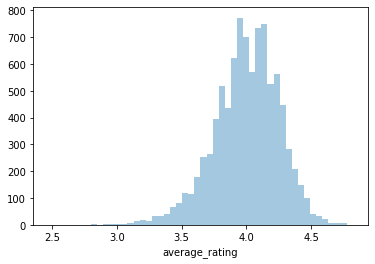

In [23]:
sns.distplot(a=books['average_rating'], kde=False);

Most of the average ratings fall between 3.5-4.5

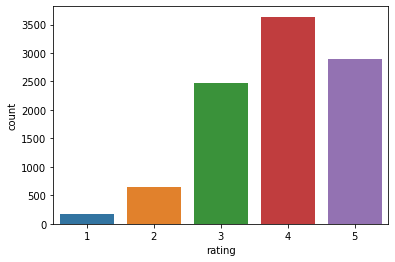

In [24]:
fig=sns.countplot(x=sample_ratings['rating']);

Most of the ratings fall between 3-5

In [25]:
top_rated=books.sort_values('average_rating', ascending=False)
top10=top_rated.head(10)
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [26]:



def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
The Complete Calvin and Hobbes,
"Words of Radiance (The Stormlight Archive, #2)",
Mark of the Lion Trilogy,
It's a Magical World: A Calvin and Hobbes Collection,
There's Treasure Everywhere: A Calvin and Hobbes Collection,
"Harry Potter Boxset (Harry Potter, #1-7)",
"Harry Potter Collection (Harry Potter, #1-6)",
The Indispensable Calvin and Hobbes,
The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury,


Top 10 rated books

In [27]:
most_pop=books.sort_values('ratings_count', ascending=False)
pop10=most_pop.head(10)
f=['title','small_image_url']
displ1=(pop10[f])
displ1.set_index('title', inplace=True)

In [28]:


def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ1.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
"The Hunger Games (The Hunger Games, #1)",
"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
To Kill a Mockingbird,
The Great Gatsby,
The Fault in Our Stars,
The Hobbit,
The Catcher in the Rye,
Pride and Prejudice,
"Angels & Demons (Robert Langdon, #1)",


Top 10 most popular books by ratings

In [29]:
authors=books.groupby('authors').agg({'average_rating':'mean','ratings_count':'sum'}).reset_index()
top_rated_authors=authors.sort_values('average_rating', ascending=False).head(10)[['authors','average_rating']]
most_pop_authors=authors.sort_values('ratings_count', ascending=False).head(10)[['authors','ratings_count']]

C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0, flags=flags)


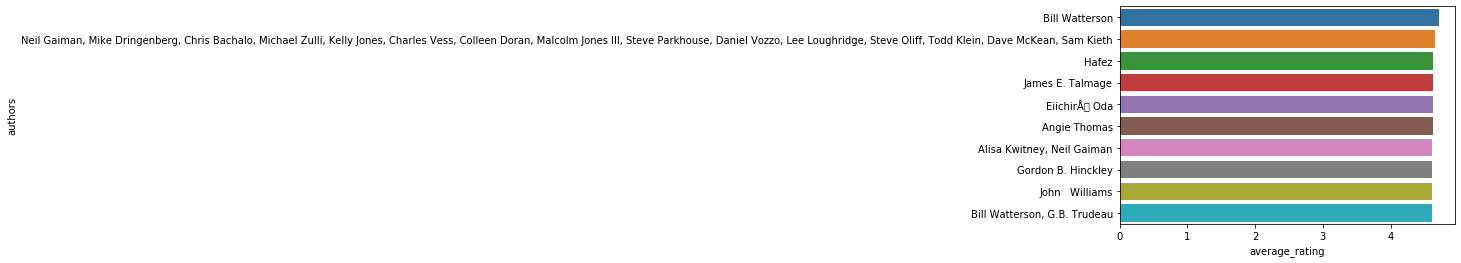

In [30]:
sns.barplot(data=top_rated_authors,x='average_rating',y='authors');

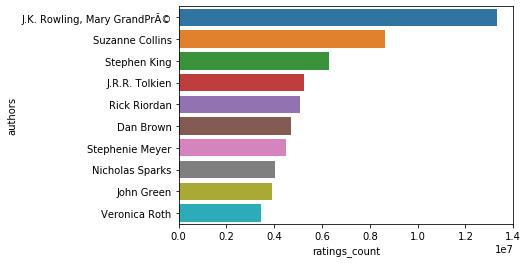

In [31]:
sns.barplot(data=most_pop_authors,x='ratings_count',y='authors');


Number of ratings per user

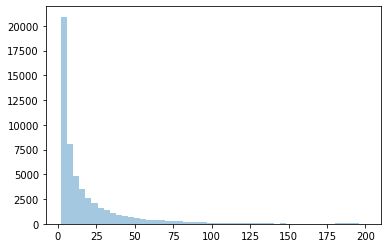

In [32]:
sns.distplot(ratings.groupby('user_id').agg({'rating':'count'}),kde=False)

Number of ratings per book

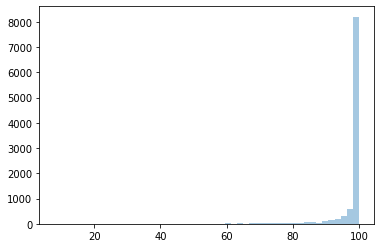

In [33]:
sns.distplot(ratings.groupby('book_id').agg({'rating':'count'}),kde=False);

Let's explore which genres are more famous

In [34]:
genres=["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics", "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction", "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror", "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction", "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]
for i in range(len(genres)):
    genres[i]=genres[i].lower()

In [35]:
joint_tag=tags.merge(book_tags,on='tag_id',how='inner')
p=joint_tag.groupby('tag_name').count()
p=p.sort_values(by='count', ascending=False)
p

,tag_id,goodreads_book_id,count
tag_name,,,
to-read,9983,9983,9983
favorites,9881,9881,9881
owned,9856,9856,9856
books-i-own,9799,9799,9799
currently-reading,9776,9776,9776
library,9415,9415,9415
owned-books,9221,9221,9221
fiction,9097,9097,9097
to-buy,8692,8692,8692


In [36]:
new_tags=p[p.index.isin(genres)]
#new_tags.reset_index()

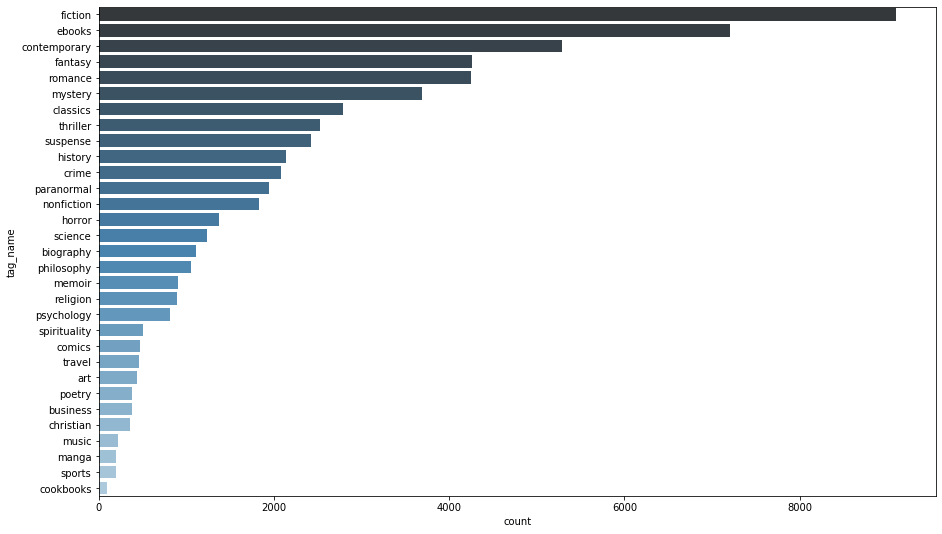

In [37]:
plt.figure(figsize=(15,9))
sns.barplot(x="count", y=new_tags.index,   data=new_tags,palette="Blues_d");


In [38]:
new_tags

,tag_id,goodreads_book_id,count
tag_name,,,
fiction,9097,9097,9097
ebooks,7203,7203,7203
contemporary,5287,5287,5287
fantasy,4259,4259,4259
romance,4251,4251,4251
mystery,3686,3686,3686
classics,2785,2785,2785
thriller,2522,2522,2522
suspense,2419,2419,2419


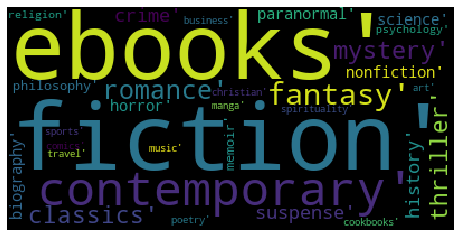

In [39]:
from wordcloud import WordCloud, STOPWORDS 
text = new_tags.index.values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Recommendation system
### 1.Content based

In [40]:
fillnabooks= books.fillna('')
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [41]:
features=['original_title','authors','average_rating']
fillednabooks=fillnabooks[features]

In [42]:
fillednabooks = fillednabooks.astype(str)
fillednabooks.dtypes

original_title    object
authors           object
average_rating    object
dtype: object

In [43]:
for feature in features:
    fillednabooks[feature] = fillednabooks[feature].apply(clean_data)
    
fillednabooks.head()

,original_title,authors,average_rating
0,thehungergames,suzannecollins,4.34
1,harrypotterandthephilosopher'sstone,"j.k.rowling,marygrandprã©",4.44
3,tokillamockingbird,harperlee,4.25
4,thegreatgatsby,f.scottfitzgerald,3.89
5,thefaultinourstars,johngreen,4.26


In [44]:
def create_soup(x):
    return x['original_title']+ ' ' + x['authors'] + ' ' + x['average_rating']

In [45]:
fillednabooks['soup'] = fillednabooks.apply(create_soup, axis=1)
fillednabooks

,original_title,authors,average_rating,soup
0,thehungergames,suzannecollins,4.34,thehungergames suzannecollins 4.34
1,harrypotterandthephilosopher'sstone,"j.k.rowling,marygrandprã©",4.44,"harrypotterandthephilosopher'sstone j.k.rowling,marygrandprã© 4.44"
3,tokillamockingbird,harperlee,4.25,tokillamockingbird harperlee 4.25
4,thegreatgatsby,f.scottfitzgerald,3.89,thegreatgatsby f.scottfitzgerald 3.89
5,thefaultinourstars,johngreen,4.26,thefaultinourstars johngreen 4.26
6,thehobbitorthereandbackagain,j.r.r.tolkien,4.25,thehobbitorthereandbackagain j.r.r.tolkien 4.25
7,thecatcherintherye,j.d.salinger,3.79,thecatcherintherye j.d.salinger 3.79
8,angels&demons,danbrown,3.85,angels&demons danbrown 3.85
9,prideandprejudice,janeausten,4.24,prideandprejudice janeausten 4.24
10,thekiterunner,khaledhosseini,4.26,thekiterunner khaledhosseini 4.26


In [46]:


count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(fillednabooks['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)


In [47]:
#from pandas import DataFrame
#count_matrix[:,1]
#print(DataFrame(count_matrix[0,:].A, columns=count.get_feature_names()).to_string())

In [48]:
fillednabooks=fillednabooks.reset_index()
indices = pd.Series(fillednabooks.index, index=fillednabooks['original_title'])
indices

original_title
thehungergames                                                                                       0   
harrypotterandthephilosopher'sstone                                                                  1   
tokillamockingbird                                                                                   2   
thegreatgatsby                                                                                       3   
thefaultinourstars                                                                                   4   
thehobbitorthereandbackagain                                                                         5   
thecatcherintherye                                                                                   6   
angels&demons                                                                                        7   
prideandprejudice                                                                                    8   
thekiterunner                  

In [49]:
def get_recommendations_new(title, cosine_sim=cosine_sim2):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return books['original_title'].iloc[movie_indices]

In [50]:
import plotly.graph_objects as go
l=get_recommendations_new('The Great Gatsby', cosine_sim2)
pd.DataFrame(l)


,original_title
7408,The Short Stories of F. Scott Fitzgerald
440,Under the Dome
473,The God Delusion
525,Darkly Dreaming Dexter
599,Torment
663,Breakfast at Tiffany's
713,The Tragedie of King Lear
835,The Unlikely Pilgrimage of Harold Fry
944,Passion
962,The Partner


In [51]:
l=get_recommendations_new('Harry Potter and The Chamber of Secrets', cosine_sim2)
fig = go.Figure(data=[go.Table(header=dict(values=l,fill_color='orange'))
                     ])
pd.DataFrame(l)

,original_title
20,Harry Potter and the Order of the Phoenix
23,Harry Potter and the Goblet of Fire
24,Harry Potter and the Deathly Hallows
2100,Harry Potter Boxed Set Books 1-4
1,Harry Potter and the Philosopher's Stone
17,Harry Potter and the Prisoner of Azkaban
26,Harry Potter and the Half-Blood Prince
341,The Casual Vacancy
393,Shadow Kiss
398,The Tales of Beedle the Bard


### 2. Collaborative approach

In [52]:
usecols=['book_id', 'original_title']
books_col=books[usecols]

In [53]:
books_col.fillna(0)

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby
5,11870085,The Fault in Our Stars
6,5907,The Hobbit or There and Back Again
7,5107,The Catcher in the Rye
8,960,Angels & Demons
9,1885,Pride and Prejudice
10,77203,The Kite Runner


In [93]:

train_data, test_data = train_test_split(sample_ratings, test_size=0.2)


In [94]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.to_numpy()
test_data_matrix = test_data.to_numpy()

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(7854, 3)
(1964, 3)


In [108]:


# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.99999305 0.98214809 0.27808018]
 [0.99999305 1.         0.98284237 0.28165833]
 [0.98214809 0.98284237 1.         0.45380581]
 [0.27808018 0.28165833 0.45380581 1.        ]]


In [110]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[1.         0.04438008 0.00622795]
 [0.04438008 1.         0.07972604]
 [0.00622795 0.07972604 1.        ]]


In [111]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [101]:


# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [112]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 11159.897125349724
Item-based CF RMSE: 12445.548763246125


In [107]:
predict(train_data_matrix, user_correlation, type='user')
train_data_matrix - train_data_matrix.mean(axis=1)[:, np.newaxis]

array([[-12608.        ,  28151.        , -15543.        ],
       [-10194.33333333,  22927.66666667, -12733.33333333],
       [ -5533.66666667,  19801.33333333, -14267.66666667],
       ...,
       [ -3830.33333333,   8111.66666667,  -4281.33333333],
       [-10765.33333333,  21589.66666667, -10824.33333333],
       [-11875.33333333,  29171.66666667, -17296.33333333]])

### 3. SVD

In [54]:
sample_rating = sample_ratings
#Ratings matrix to be one row per user and one column per movie.
print("Total Books: ", sample_rating.shape[0])
## Total User only considering user who rated atleast one movie
print("Total User: ", len(sample_rating['user_id'].unique()))


Total Books:  9818
Total User:  7734


In [55]:
books = books[['book_id', 'authors', 'original_title', 'average_rating']].copy()
books_df = sample_rating.reset_index().pivot_table(index = 'user_id', columns = 'book_id', values = 'rating').fillna(0)
print(books_df.head(), books_df.shape)

book_id    1    2    4    5    6    7   10   12   14   15  ...  9987  9988  \
user_id                                                    ...               
7        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
21       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
22       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
27       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
36       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    

book_id  9989  9990  9991  9992  9994  9995  9997  9999  
user_id                                                  
7        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
21       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
36       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

[5 rows x 6256 columns] (7734, 6256)


In [68]:
# Normalize by each users mean and convert it from a dataframe to a numpy array
R = books_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
R_demeaned

C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
del(R_demeaned)
sigma = np.diag(sigma)
print(sigma)

[[10.25677608  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         10.28420697  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         10.29755886 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 12.06819958  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         12.25743804
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  12.68164915]]


In [70]:
# add the user means back to get the predicted 5-star ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
print(all_user_predicted_ratings)
# Making Recommendation
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = books_df.columns)
print(preds_df.head(5))

[[0.00063939 0.00063939 0.00063939 ... 0.00063939 0.00063939 0.00063939]
 [0.00047954 0.00047954 0.00047954 ... 0.00047954 0.00047954 0.00047954]
 [0.00047954 0.00047954 0.00047954 ... 0.00047954 0.00047954 0.00047954]
 ...
 [0.00063939 0.00063939 0.00063939 ... 0.00063939 0.00063939 0.00063939]
 [0.00076518 0.00031969 0.00031969 ... 0.00031969 0.00031969 0.00031969]
 [0.00047954 0.00047954 0.00047954 ... 0.00047954 0.00047954 0.00047954]]
book_id         1         2         4         5         6         7        10  \
0        0.000639  0.000639  0.000639  0.000639  0.000639  0.000639  0.000639   
1        0.000480  0.000480  0.000480  0.000480  0.000480  0.000480  0.000480   
2        0.000480  0.000480  0.000480  0.000480  0.000480  0.000480  0.000480   
3        0.000799  0.000799  0.000799  0.000799  0.000799  0.000799  0.000799   
4        0.000799  0.000799  0.000799  0.000799  0.000799  0.000799  0.000799   

book_id        12        14        15  ...      9987      9988      9

In [71]:
def recommend_books(predictions_df, userID, books_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (userID)]
    user_full = (user_data.merge(books_df, how = 'left', left_on = 'book_id', right_on = 'book_id').
                     sort_values(['rating'], ascending=False)
                 )

#     print 'User {0} has already rated {1} books.', %(.format(userID, user_full.shape[0]))
#     print 'Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations)
    
    # Recommend the highest predicted rating books that the user hasn't read yet.
    recommendations = (books_df[~books_df['book_id'].isin(user_full['book_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'book_id',
               right_on = 'book_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return(user_full, recommendations)


In [72]:
already_rated, predictions = recommend_books(preds_df, 121, books, ratings, 10)
print(pd.DataFrame(predictions))

      book_id  \
3215  1362      
5412  3300      
7117  98        
241   662       
1278  360       
2678  105       
245   4865      
6851  1191      
1913  5306      
3874  5695      

                                                                                            authors  \
3215  Herodotus, Aubrey de SÃ©lincourt, John M. Marincola                                             
5412  Isabel Allende, Margaret Sayers Peden                                                           
7117  Heidi Murkoff, Sharon Mazel, Heidi Murkoff, Arlene Eisenberg, Sandee Hathaway, Mark D. Widome   
241   Ayn Rand, Leonard Peikoff                                                                       
1278  Douglas Adams                                                                                   
2678  Frank Herbert                                                                                   
245   Dale Carnegie                                                                        

In [73]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(sample_rating[['user_id', 'book_id', 'rating']], reader)

# Split the dataset for 5-fold evaluation
#data = data.build_full_trainset()
#data.split(n_folds=5)

In [74]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'],verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9434  0.9674  0.9752  0.9606  0.9629  0.9619  0.0105  
Fit time          0.43    0.45    0.46    0.42    0.42    0.44    0.02    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.94341289, 0.96739139, 0.97521926, 0.96055481, 0.96294838]),
 'fit_time': (0.43184828758239746,
  0.4499936103820801,
  0.45977115631103516,
  0.4189178943634033,
  0.4228174686431885),
 'test_time': (0.012965917587280273,
  0.010883331298828125,
  0.010970592498779297,
  0.008964061737060547,
  0.009995222091674805)}

In [65]:
sample_rating[sample_rating['user_id'] == 21].head()

,book_id,user_id,rating
932956,9473,21,3


In [66]:
svd.predict(21, 1994)


Prediction(uid=21, iid=1994, r_ui=None, est=3.832077317690643, details={'was_impossible': False})